In [1]:
# # imports all helper classes/functions from utils.py, including other dependancies
# from utils_new import *

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


class Dataset():
    def __init__(self, filenames, apt_filename):
        
        self.num_concs = len(filenames)
        self.num_devices = 10000
        self.num_voltages = 10000
        for conc in range(self.num_concs):
            raw_data = np.loadtxt('data/'+filenames[conc]).T
            self.voltages = raw_data[0,:]
            self.num_devices = min(raw_data.shape[0] - 1, self.num_devices)
            self.num_voltages = max(len(self.voltages), self.num_voltages)
        self.voltages = self.voltages[:self.num_voltages]

        # self.resistances = np.zeros((self.num_concs, self.num_devices, self.num_voltages))
        # for conc in range(self.num_concs):
        #     conc_raw_data = np.loadtxt('data/'+filenames[conc]).T
        #     for dev_num in range(self.num_devices):
        #         self.resistances[conc,dev_num,:] = conc_raw_data[dev_num+1][:len(self.voltages)]
        
        self.apt_resistances = {}
        for dev_num in range(self.num_devices):
            raw_data = np.loadtxt('data/'+apt_filename).T
            self.apt_resistances[dev_num] = raw_data[dev_num+1]
        self.resistances = {}
        for conc in range(self.num_concs):
            conc_data_dic = {}
            for dev_num in range(self.num_devices):
                raw_data = np.loadtxt('data/'+filenames[conc]).T
                conc_data_dic[dev_num] = raw_data[dev_num+1]
            self.resistances[conc] = conc_data_dic

        self.resistance_derivatives = {}
        for conc in range(self.num_concs):
            conc_resistance_derivative = {}
            for dev_num in range(self.num_devices): 
                conc_resistance_derivative[dev_num] = [self.resistances[conc][dev_num][i] - self.resistances[conc][dev_num][i+1] for i in range(len(self.resistances[conc][dev_num])-1)]
            self.resistance_derivatives[conc] = conc_resistance_derivative
        self.apt_resistance_derivatives = {}
        for dev_num in range(self.num_devices): 
            self.apt_resistance_derivatives[dev_num] = [self.apt_resistances[dev_num][i] - self.apt_resistances[dev_num][i+1] for i in range(len(self.apt_resistances[dev_num])-1)]

        self.apt_dirac_voltages = {}
        for dev_num in range(self.num_devices):
            self.apt_dirac_voltages[dev_num] = self.voltages[np.argmax(self.apt_resistances[dev_num])]
        self.dirac_voltages = np.zeros((self.num_concs, self.num_devices))
        self.adj_dirac_voltages = np.zeros((self.num_concs, self.num_devices))
        for conc in range(self.num_concs):
            for dev_num in range(self.num_devices):
                self.dirac_voltages[conc,dev_num] = self.voltages[np.argmax(self.resistances[conc][dev_num])]
                self.adj_dirac_voltages[conc,dev_num] = self.voltages[np.argmax(self.resistances[conc][dev_num])] - self.apt_dirac_voltages[dev_num]

        self.apt_pos_transc_voltages = {}
        self.apt_neg_transc_voltages = {}
        for dev_num in range(self.num_devices):
                self.apt_pos_transc_voltages[dev_num] = self.voltages[np.argmax(self.apt_resistance_derivatives[dev_num])]
                self.apt_neg_transc_voltages[dev_num] = self.voltages[np.argmin(self.apt_resistance_derivatives[dev_num])]
        self.pos_transc_voltages = np.zeros((self.num_concs, self.num_devices))
        self.neg_transc_voltages = np.zeros((self.num_concs, self.num_devices))
        self.adj_pos_transc_voltages = np.zeros((self.num_concs, self.num_devices))
        self.adj_neg_transc_voltages = np.zeros((self.num_concs, self.num_devices))
        for conc in range(self.num_concs):
            for dev_num in range(self.num_devices):
                self.pos_transc_voltages[conc, dev_num] = self.voltages[np.argmax(self.resistance_derivatives[conc][dev_num])]
                self.neg_transc_voltages[conc, dev_num] = self.voltages[np.argmin(self.resistance_derivatives[conc][dev_num])]
                self.adj_pos_transc_voltages[conc, dev_num] = self.voltages[np.argmax(self.resistance_derivatives[conc][dev_num])] - self.apt_pos_transc_voltages[dev_num]
                self.adj_neg_transc_voltages[conc, dev_num] = self.voltages[np.argmin(self.resistance_derivatives[conc][dev_num])] - self.apt_neg_transc_voltages[dev_num]

        
        self.apt_conductances = {dev_num: 1/self.apt_resistances[dev_num] for dev_num in range(self.num_devices)}
        self.conductances = {}
        for conc in range(self.num_concs):
            self.conductances[conc] = [1 / self.resistances[conc][dev_num] for dev_num in range(self.num_devices)]
        

        self.norm_dirac_voltages = np.zeros((self.num_concs, self.num_devices))
        for dev_num in range(self.num_devices):
            # max_dirac_voltage_shift = max(adj_dirac_voltages[:,dev_num])
            self.norm_dirac_voltages[:,dev_num] = self.adj_dirac_voltages[:,dev_num] / max(self.adj_dirac_voltages[:,dev_num])

        

    def normalized_conductance_shifts(self, voltage_to_track):
        voltage_idx = np.where(dataset.voltages == voltage_to_track)[0][0]

        conductance_at_voltage = np.zeros((self.num_concs, self.num_devices))
        for conc in range(self.num_concs):
            for dev_num in range(self.num_devices):
                conductance_at_voltage[conc, dev_num] = self.conductances[conc][dev_num][voltage_idx]

        delta_conductance = np.zeros((self.num_concs, self.num_devices))
        for dev_num in range(self.num_devices):
            delta_conductance[:,dev_num] = conductance_at_voltage[:,dev_num] - self.apt_conductances[dev_num][voltage_idx]

        max_conductance = {}
        for dev_num in range(self.num_devices):
            max_conductance[dev_num] = max(delta_conductance[:,dev_num])

        norm_conductance = np.zeros((self.num_concs, self.num_devices))
        for dev_num in range(self.num_devices):
            norm_conductance[:,dev_num] = delta_conductance[:,dev_num] / max_conductance[dev_num]

        return norm_conductance


    def conductance_shifts(self, voltage_to_track):
        voltage_idx = np.where(dataset.voltages == voltage_to_track)[0][0]

        conductance_at_voltage = np.zeros((self.num_concs, self.num_devices))
        for conc in range(self.num_concs):
            for dev_num in range(self.num_devices):
                conductance_at_voltage[conc, dev_num] = self.conductances[conc][dev_num][voltage_idx]

        delta_conductance = np.zeros((self.num_concs, self.num_devices))
        for dev_num in range(self.num_devices):
            delta_conductance[:,dev_num] = conductance_at_voltage[:,dev_num] - self.apt_conductances[dev_num][voltage_idx]

        return delta_conductance
            


        

        # normalized_conductance_at_voltage = np.zeros((self.num_concs, self.num_devices))
        # for dev_num in range(self.num_devices):
        #     # normalized_conductance_at_voltage[:,dev_num] = (conductance_at_voltage[:,dev_num] - self.apt_conductances[dev_num][voltage_idx]) / max(conductance_at_voltage[:,dev_num])
        #     normalized_conductance_at_voltage[:,dev_num] = (conductance_at_voltage[:,dev_num]) / max(conductance_at_voltage[:,dev_num])

        # return normalized_conductance_at_voltage

        
        





def hill_function(x, A, K, n, b):
    return A * (x**n) / (K**n + x**n) + b

def downward_hill_function(x, A, K, n, b):
    return A * (1 - (x**n) / (K**n + x**n)) + b
            
        

    

In [131]:
# for RSV, well 3

# filenames to inlude for each concentration
filenames = ['BCdata_B48C13_rsv_1ag_lastsweep.txt', 
             'BCdata_B48C13_rsv_10ag_lastsweep.txt', 
             'BCdata_B48C13_rsv_100ag_lastsweep.txt', 
             'BCdata_B48C13_rsv_1fg_lastsweep.txt', 
             'BCdata_B48C13_rsv_10fg_lastsweep.txt', 
             'BCdata_B48C13_rsv_100fg_lastsweep.txt', 
             'BCdata_B48C13_rsv_1pg_lastsweep.txt', 
             'BCdata_B48C13_rsv_10pg_lastsweep.txt', 
             'BCdata_B48C13_rsv_100pg_lastsweep.txt', 
             'BCdata_B48C13_rsv_1ng_lastsweep.txt']

filename_aptamer = 'BCdata_B48C13_rsv_aptamers_lastsweep.txt'

dataset = Dataset(filenames, filename_aptamer)

# print(dataset.normalized_conductance_shifts(0.9))

print(dataset.norm_dirac_voltages)


[[0.05       0.04761905 0.05263158 0.05       0.05      ]
 [0.1        0.14285714 0.10526316 0.15       0.15      ]
 [0.25       0.28571429 0.26315789 0.25       0.25      ]
 [0.45       0.47619048 0.47368421 0.45       0.45      ]
 [0.55       0.57142857 0.57894737 0.55       0.55      ]
 [0.55       0.57142857 0.52631579 0.55       0.55      ]
 [0.95       0.9047619  0.94736842 0.95       0.9       ]
 [0.9        0.9047619  0.89473684 0.95       0.9       ]
 [0.95       0.95238095 0.94736842 1.         0.9       ]
 [1.         1.         1.         1.         1.        ]]


C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\243793634.py:123: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\243793634.py:123: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\243793634.py:123: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


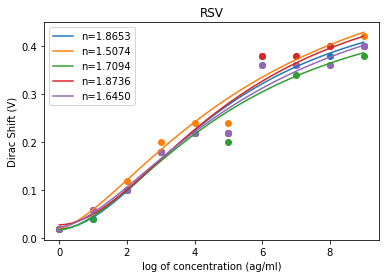

C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\243793634.py:123: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\243793634.py:123: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\243793634.py:123: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\243793634.py:123: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


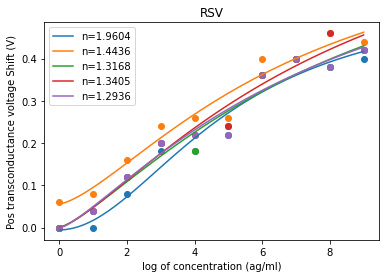

C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\243793634.py:123: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


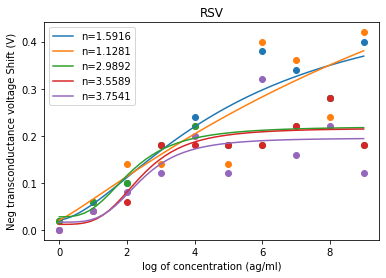

In [121]:
# dirac voltage shifts
for i in range(dataset.num_devices):
    concs = range(dataset.num_concs)
    dirac_voltages = dataset.adj_dirac_voltages[:,i]
    plt.scatter(concs, dirac_voltages, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, dirac_voltages)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Dirac Shift (V)")
plt.show()
plt.close()


# pos transconductance voltage shifts
for i in range(dataset.num_devices):
    concs = range(dataset.num_concs)
    pos_transc_voltages = dataset.adj_pos_transc_voltages[:,i]
    plt.scatter(concs, pos_transc_voltages, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, pos_transc_voltages)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Pos transconductance voltage Shift (V)")
plt.legend()
plt.show()
plt.close()

# neg transconductance voltage shifts
for i in range(dataset.num_devices):
    concs = range(dataset.num_concs)
    neg_transc_voltages = dataset.adj_neg_transc_voltages[:,i]
    plt.scatter(concs, neg_transc_voltages, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, neg_transc_voltages)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Neg transconductance voltage Shift (V)")
plt.legend()
plt.show()
plt.close()

C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\349478397.py:137: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\349478397.py:137: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\349478397.py:137: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\349478397.py:137: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


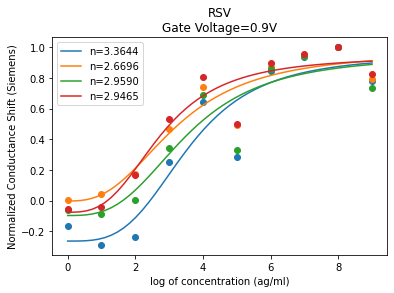

C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\349478397.py:137: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\349478397.py:137: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


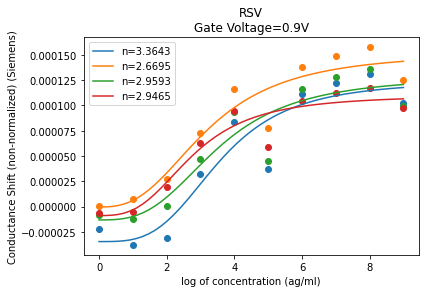

In [127]:
# conductance shifts at Gate voltage 0.9
for i in [0,1,2,4]:
    concs = range(dataset.num_concs)
    conductances = dataset.normalized_conductance_shifts(0.9)[:,i]
    plt.scatter(concs, conductances, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, conductances)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.title('RSV\nGate Voltage=0.9V')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Normalized Conductance Shift (Siemens)")
plt.show()
plt.close()

# conductance shifts at Gate voltage 0.9
for i in [0,1,2,4]:
    concs = range(dataset.num_concs)
    conductances = dataset.conductance_shifts(0.9)[:,i]
    plt.scatter(concs, conductances, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, conductances)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.title('RSV\nGate Voltage=0.9V')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Conductance Shift (non-normalized) (Siemens)")
plt.show()
plt.close()

C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\2296141488.py:143: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\2296141488.py:143: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\2296141488.py:143: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\2296141488.py:143: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\2296141488.py:143: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\2296141488.py:143: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\

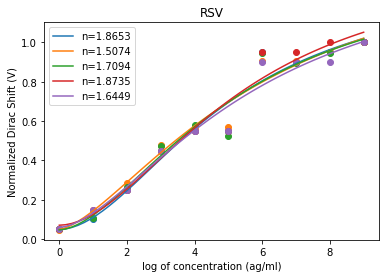

C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\2296141488.py:143: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\2296141488.py:143: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_26980\2296141488.py:143: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


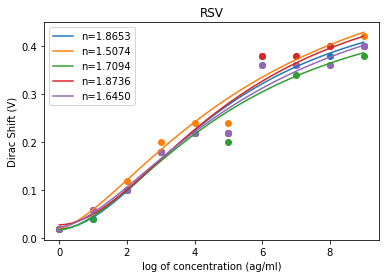

In [134]:
# normalized dirac voltage shifts
for i in range(dataset.num_devices):
    concs = range(dataset.num_concs)
    dirac_voltages = dataset.norm_dirac_voltages[:,i]
    plt.scatter(concs, dirac_voltages, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, dirac_voltages)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Normalized Dirac Shift (V)")
plt.show()
plt.close()

# dirac voltage shifts
for i in range(dataset.num_devices):
    concs = range(dataset.num_concs)
    dirac_voltages = dataset.adj_dirac_voltages[:,i]
    plt.scatter(concs, dirac_voltages, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, dirac_voltages)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Dirac Shift (V)")
plt.show()
plt.close()

In [94]:

# # makes dataset for each respective filename
# datasets = [DataSweep(filename) for filename in filenames]

# # makes list of diracs, transconductances, and conductances for all devices
# dirac_voltages = [dataset.dirac_voltages() for dataset in datasets]
# transconductance_voltages = [dataset.transconductance_voltages() for dataset in datasets]
# transconductance_conductances = [dataset.transconductance_conductances() for dataset in datasets]

# # makes lists for a specific device, and for specific pos and neg transc. datasets
# dev_num = '1'
# dev_dirac_voltages = [dev[dev_num] for dev in dirac_voltages]
# dev_transconductance_voltages_pos = [dev[dev_num + '+'] for dev in transconductance_voltages]
# dev_transconductance_voltages_neg = [dev[dev_num + '-'] for dev in transconductance_voltages]
# dev_transconductance_conductances_pos = [dev[dev_num + '+'] for dev in transconductance_conductances]
# dev_transconductance_conductances_neg = [dev[dev_num + '-'] for dev in transconductance_conductances]

# concentrations = range(0, 10)

# # calculates baselines for each calculation, from the aptemer dataset
# dataset_apt = DataSweep('BCdata_B48C13_rsv_aptamers_lastsweep.txt')
# dirac_baseline = dataset_apt.dirac_voltages()[dev_num]
# transconductance_baseline_pos = dataset_apt.transconductance_voltages()[dev_num+'+']
# transconductance_baseline_neg = dataset_apt.transconductance_voltages()[dev_num+'-']
# transconductance_conductances_baseline_pos = dataset_apt.transconductance_conductances()[dev_num+'+']
# transconductance_conductances_baseline_neg = dataset_apt.transconductance_conductances()[dev_num+'-']

# # adjusts values based on the baselines
# adj_dev_dirac_voltages = [val - dirac_baseline for val in dev_dirac_voltages]
# adj_dev_transconductance_voltages_pos = [val - transconductance_baseline_pos for val in dev_transconductance_voltages_pos]
# adj_dev_transconductance_voltages_neg = [val - transconductance_baseline_neg for val in dev_transconductance_voltages_neg]
# adj_dev_transconductance_conductances_pos = [val - transconductance_conductances_baseline_pos for val in dev_transconductance_conductances_pos]
# adj_dev_transconductance_conductances_neg = [val - transconductance_conductances_baseline_neg for val in dev_transconductance_conductances_neg]

# # dirac voltage shifts
# plt.scatter(concentrations, adj_dev_dirac_voltages, marker='o')
# plt.title('RSV')
# plt.xlabel("log of concentration (ag/ml)")
# plt.ylabel("Dirac Shift (V)")
# coeffs, pcov = curve_fit(hill_function, concentrations, adj_dev_dirac_voltages, p0=[1,1,1])
# X_fit = np.linspace(min(concentrations), max(concentrations), 50)
# hill_function(X_fit, *coeffs)
# Y_fit = hill_function(X_fit, *coeffs)
# plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
# plt.legend()
# plt.show()
# plt.close()

# # pos transconductance voltage shifts
# plt.scatter(concentrations, adj_dev_transconductance_voltages_pos, marker='o')
# plt.title('RSV')
# plt.xlabel("log of concentration (ag/ml)")
# plt.ylabel("Pos transconductance voltage Shift (V)")
# coeffs, pcov = curve_fit(hill_function, concentrations, adj_dev_transconductance_voltages_pos, p0=[1,1,1])
# X_fit = np.linspace(min(concentrations), max(concentrations), 50)
# hill_function(X_fit, *coeffs)
# Y_fit = hill_function(X_fit, *coeffs)
# plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
# plt.legend()
# plt.show()
# plt.close()

# # neg transconductance voltage shifts
# plt.scatter(concentrations, adj_dev_transconductance_voltages_neg, marker='o')
# plt.title('RSV')
# plt.xlabel("log of concentration (ag/ml)")
# plt.ylabel("Neg transconductance voltage Shift (V)")
# coeffs, pcov = curve_fit(hill_function, concentrations, adj_dev_transconductance_voltages_neg, p0=[1,1,1])
# X_fit = np.linspace(min(concentrations), max(concentrations), 50)
# hill_function(X_fit, *coeffs)
# Y_fit = hill_function(X_fit, *coeffs)
# plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
# plt.legend()
# plt.show()
# plt.close()

# # pos transconductance conductance shifts
# plt.scatter(concentrations, adj_dev_transconductance_conductances_pos, marker='o')
# plt.title('RSV')
# plt.xlabel("log of concentration (ag/ml)")
# plt.ylabel("Pos transconductance conductance Shift (Siemens)")
# coeffs, pcov = curve_fit(downward_hill_function, concentrations, adj_dev_transconductance_conductances_pos, p0=[1,1,1])
# X_fit = np.linspace(min(concentrations), max(concentrations), 50)
# hill_function(X_fit, *coeffs)
# Y_fit = downward_hill_function(X_fit, *coeffs)
# plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
# plt.legend()
# plt.show()
# plt.close()

# # neg transconductance conductance shifts
# plt.scatter(concentrations, adj_dev_transconductance_conductances_neg, marker='o')
# plt.title('RSV')
# plt.xlabel("log of concentration (ag/ml)")
# plt.ylabel("Neg transconductance conductance Shift (Siemens)")
# coeffs, pcov = curve_fit(downward_hill_function, concentrations, adj_dev_transconductance_conductances_neg, p0=[1,1,1])
# X_fit = np.linspace(min(concentrations), max(concentrations), 50)
# hill_function(X_fit, *coeffs)
# Y_fit = downward_hill_function(X_fit, *coeffs)
# plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
# plt.legend()
# plt.show()
# plt.close()

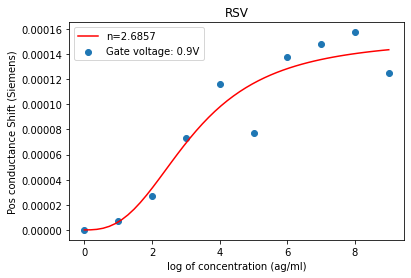

In [45]:
# tracks the conductance values over different concentrations, for a single voltage

conductances_track = []
voltage_to_track = 0.9
conductances_track = [1/dataset.data[dev_num][np.where(dataset.data['voltages'] == voltage_to_track)[0]][0] for dataset in datasets]

# calculates baselines from the aptemer dataset, for conductance. Then adjusts baseline accordingly
dataset_apt = DataSweep('BCdata_B48C13_rsv_aptamers_lastsweep.txt')
conductance_baseline = 1/dataset_apt.data[dev_num][np.where(dataset_apt.data['voltages'] == voltage_to_track)[0]][0]
adj_conductances_track = [val - conductance_baseline for val in conductances_track]

# plotting
plt.scatter(concentrations, adj_conductances_track, marker='o', label=f'Gate voltage: {voltage_to_track}V')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Pos conductance Shift (Siemens)")

coeffs, pcov = curve_fit(hill_function, concentrations, adj_conductances_track, p0=[1,1,1])
X_fit = np.linspace(min(concentrations), max(concentrations), 50)
hill_function(X_fit, *coeffs)
Y_fit = hill_function(X_fit, *coeffs)
plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')

# coefficients = np.polyfit(concentrations, adj_conductances_track, 4)  # 4 is the degree of the polynomial
# polynomial = np.poly1d(coefficients)
# X_fit = np.linspace(min(concentrations), max(concentrations), 100)
# Y_fit = polynomial(X_fit)
# plt.plot(X_fit, Y_fit, color='red')

plt.legend()
plt.show()
plt.close()


In [ ]:
# for RSV, well 3

# filenames to inlude for each concentration
filenames = ['BCdata_B48C13_rsv_1ag_lastsweep.txt', 
             'BCdata_B48C13_rsv_10ag_lastsweep.txt', 
             'BCdata_B48C13_rsv_100ag_lastsweep.txt', 
             'BCdata_B48C13_rsv_1fg_lastsweep.txt', 
             'BCdata_B48C13_rsv_10fg_lastsweep.txt', 
             'BCdata_B48C13_rsv_100fg_lastsweep.txt', 
             'BCdata_B48C13_rsv_1pg_lastsweep.txt', 
             'BCdata_B48C13_rsv_10pg_lastsweep.txt', 
             'BCdata_B48C13_rsv_100pg_lastsweep.txt', 
             'BCdata_B48C13_rsv_1ng_lastsweep.txt']

# makes dataset for each respective filename
datasets = [DataSweep(filename) for filename in filenames]

# makes list of diracs, transconductances, and conductances for all devices
dirac_voltages = [dataset.dirac_voltages() for dataset in datasets]
transconductance_voltages = [dataset.transconductance_voltages() for dataset in datasets]
transconductance_conductances = [dataset.transconductance_conductances() for dataset in datasets]

# makes lists for a specific device, and for specific pos and neg transc. datasets
dev_num = '1'
dev_dirac_voltages = [dev[dev_num] for dev in dirac_voltages]
dev_transconductance_voltages_pos = [dev[dev_num + '+'] for dev in transconductance_voltages]
dev_transconductance_voltages_neg = [dev[dev_num + '-'] for dev in transconductance_voltages]
dev_transconductance_conductances_pos = [dev[dev_num + '+'] for dev in transconductance_conductances]
dev_transconductance_conductances_neg = [dev[dev_num + '-'] for dev in transconductance_conductances]

concentrations = range(0, 10)

# calculates baselines for each calculation, from the aptemer dataset
dataset_apt = DataSweep('BCdata_B48C13_rsv_aptamers_lastsweep.txt')
dirac_baseline = dataset_apt.dirac_voltages()[dev_num]
transconductance_baseline_pos = dataset_apt.transconductance_voltages()[dev_num+'+']
transconductance_baseline_neg = dataset_apt.transconductance_voltages()[dev_num+'-']
transconductance_conductances_baseline_pos = dataset_apt.transconductance_conductances()[dev_num+'+']
transconductance_conductances_baseline_neg = dataset_apt.transconductance_conductances()[dev_num+'-']

# adjusts values based on the baselines
adj_dev_dirac_voltages = [val - dirac_baseline for val in dev_dirac_voltages]
adj_dev_transconductance_voltages_pos = [val - transconductance_baseline_pos for val in dev_transconductance_voltages_pos]
adj_dev_transconductance_voltages_neg = [val - transconductance_baseline_neg for val in dev_transconductance_voltages_neg]
adj_dev_transconductance_conductances_pos = [val - transconductance_conductances_baseline_pos for val in dev_transconductance_conductances_pos]
adj_dev_transconductance_conductances_neg = [val - transconductance_conductances_baseline_neg for val in dev_transconductance_conductances_neg]

# dirac voltage shifts
plt.scatter(concentrations, adj_dev_dirac_voltages, marker='o')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Dirac Shift (V)")
coeffs, pcov = curve_fit(hill_function, concentrations, adj_dev_dirac_voltages, p0=[1,1,1])
X_fit = np.linspace(min(concentrations), max(concentrations), 50)
hill_function(X_fit, *coeffs)
Y_fit = hill_function(X_fit, *coeffs)
plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.show()
plt.close()

# pos transconductance voltage shifts
plt.scatter(concentrations, adj_dev_transconductance_voltages_pos, marker='o')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Pos transconductance voltage Shift (V)")
coeffs, pcov = curve_fit(hill_function, concentrations, adj_dev_transconductance_voltages_pos, p0=[1,1,1])
X_fit = np.linspace(min(concentrations), max(concentrations), 50)
hill_function(X_fit, *coeffs)
Y_fit = hill_function(X_fit, *coeffs)
plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.show()
plt.close()

# neg transconductance voltage shifts
plt.scatter(concentrations, adj_dev_transconductance_voltages_neg, marker='o')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Neg transconductance voltage Shift (V)")
coeffs, pcov = curve_fit(hill_function, concentrations, adj_dev_transconductance_voltages_neg, p0=[1,1,1])
X_fit = np.linspace(min(concentrations), max(concentrations), 50)
hill_function(X_fit, *coeffs)
Y_fit = hill_function(X_fit, *coeffs)
plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.show()
plt.close()

# pos transconductance conductance shifts
plt.scatter(concentrations, adj_dev_transconductance_conductances_pos, marker='o')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Pos transconductance conductance Shift (Siemens)")
coeffs, pcov = curve_fit(downward_hill_function, concentrations, adj_dev_transconductance_conductances_pos, p0=[1,1,1])
X_fit = np.linspace(min(concentrations), max(concentrations), 50)
hill_function(X_fit, *coeffs)
Y_fit = downward_hill_function(X_fit, *coeffs)
plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.show()
plt.close()

# neg transconductance conductance shifts
plt.scatter(concentrations, adj_dev_transconductance_conductances_neg, marker='o')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Neg transconductance conductance Shift (Siemens)")
coeffs, pcov = curve_fit(downward_hill_function, concentrations, adj_dev_transconductance_conductances_neg, p0=[1,1,1])
X_fit = np.linspace(min(concentrations), max(concentrations), 50)
hill_function(X_fit, *coeffs)
Y_fit = downward_hill_function(X_fit, *coeffs)
plt.plot(X_fit, Y_fit, color='red', label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.show()
plt.close()